In [1]:
from utils import train_load_datasets_resnet as tr
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import random_split
from torchvision import transforms
import torch
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataflag = 'organamnist'
color = True # True for color, False for grayscale
im_size = 224
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')  
batch_size = 4000  # Batch size for the DataLoader

if color is True:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
    ])
    
else:
    # For grayscale images, repeat the single channel to make it compatible with ResNet
    # ResNet expects 3 channels, so we repeat the single channel image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5]),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])

In [3]:
datasets, loaders, info = tr.load_datasets(dataflag, color=color, im_size=im_size, transform=transform, batch_size=batch_size)

Training dataset size: 32841
Calibration dataset size: 8211


In [4]:
datasets[2]

Dataset OrganAMNIST of size 224 (organamnist_224)
    Number of datapoints: 17778
    Root location: /home/psteinmetz/.medmnist
    Split: test
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34561, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to pe

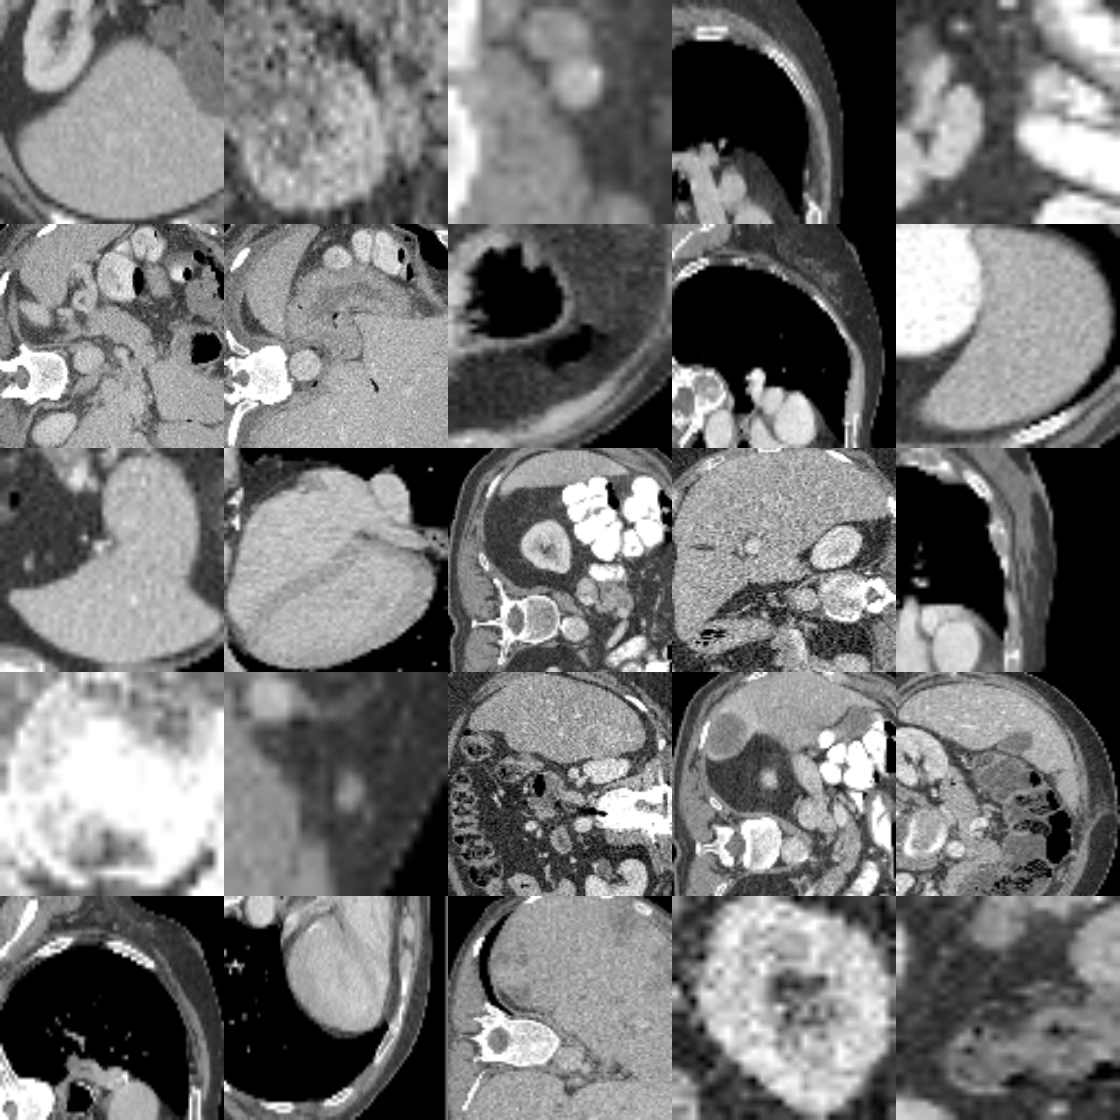

In [5]:
datasets[2].montage(length=5)

In [16]:
def train_val_loaders(train_dataset, batch_size):
    # Create stratified K-fold cross-validator
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get the labels for stratification
    labels = [label for _, label in train_dataset]

    # Create a list to store the new dataloaders
    train_loaders = []
    val_loaders = []

    for train_index, val_index in skf.split(np.zeros(len(labels)), labels):
        train_subset = torch.utils.data.Subset(train_dataset, train_index)
        val_subset = torch.utils.data.Subset(train_dataset, val_index)
        
        train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=True, drop_last=True)
        
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)
    return train_loaders, val_loaders

In [26]:
flag = 'organamnist'
color = False  # Colors for the flags
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
size = 224  # Image size for the models

if color is True:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
    ])
    
    transform_tta = transforms.Compose([
        transforms.ToTensor()
    ])
else:
    # For grayscale images, repeat the single channel to make it compatible with ResNet
    # ResNet expects 3 channels, so we repeat the single channel image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5]),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])
    
    transform_tta = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
        ])

[train_dataset, calibration_dataset, test_dataset], [train_loader, calibration_loader, test_loader], info = tr.load_datasets(flag, color, size, transform, batch_size)
train_loaders, val_loaders = train_val_loaders(train_dataset, batch_size=batch_size)
[_, calibration_dataset_tta, test_dataset_tta], [_, calibration_loader_tta, test_loader_tta], _ = tr.load_datasets(flag, color, size, transform_tta, batch_size)

Training dataset size: 32841
Calibration dataset size: 8211
Training dataset size: 32841
Calibration dataset size: 8211


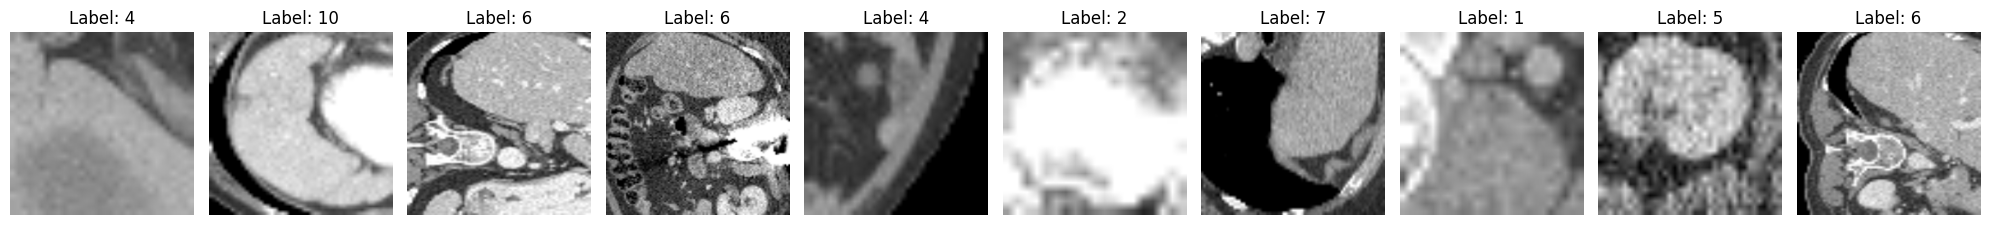

In [29]:
# Display the next 10 images and their labels from the test_loader
images, labels = next(iter(test_loader_tta))

fig, axes = plt.subplots(1, 10, figsize=(20, 10))
for i in range(40, 50):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    if img.shape[2] == 1:
        img = img.squeeze(2)
        axes[i - 40].imshow(img, cmap='gray')
    else:
        axes[i - 40].imshow(img)
    axes[i - 40].set_title(f"Label: {labels[i].item()}")
    axes[i - 40].axis('off')
plt.tight_layout()
plt.show()


In [6]:
datasets[2]

Dataset OrganAMNIST of size 224 (organamnist_224)
    Number of datapoints: 17778
    Root location: /home/psteinmetz/.medmnist
    Split: test
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34561, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to pe

In [6]:
# Combine train_dataset and val_dataset
combined_train_dataset = ConcatDataset([datasets[0], datasets[1]])

# Set the random seed for reproducibility
torch.manual_seed(42)

# Calculate the sizes for training and calibration datasets
train_size = int(0.8 * len(combined_train_dataset))
calibration_size = len(combined_train_dataset) - train_size

# Split the combined_train_dataset into training and calibration datasets
train_dataset, calibration_dataset = random_split(combined_train_dataset, [train_size, calibration_size])

# Create DataLoaders for the new training and calibration datasets
calibration_loader = DataLoader(dataset=calibration_dataset, batch_size=batch_size, shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Calibration dataset size: {len(calibration_dataset)}')

Training dataset size: 151284
Calibration dataset size: 37822


In [7]:
# Create stratified K-fold cross-validator
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Get the labels for stratification
labels = [label for _, label in train_dataset]

# Create a list to store the new dataloaders
train_loaders = []
val_loaders = []

for train_index, val_index in skf.split(np.zeros(len(labels)), labels):
    train_subset = torch.utils.data.Subset(train_dataset, train_index)
    val_subset = torch.utils.data.Subset(train_dataset, val_index)
    
    train_loader = DataLoader(dataset=train_subset, shuffle=True, drop_last=True, batch_size=batch_size)
    val_loader = DataLoader(dataset=val_subset, shuffle=True, drop_last=True, batch_size=batch_size)
    
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

In [8]:
test_loader = DataLoader(dataset=datasets[2], shuffle=False, batch_size=batch_size)

MODEL 0
Train Epoch: 0 [0/121027 (0%)]	Loss: 2.345891
Train Epoch: 0 [3600/121027 (3%)]	Loss: 1.381243
Train Epoch: 0 [7200/121027 (6%)]	Loss: 1.286229
Train Epoch: 0 [10800/121027 (9%)]	Loss: 1.305520
Train Epoch: 0 [14400/121027 (12%)]	Loss: 1.106190
Train Epoch: 0 [18000/121027 (15%)]	Loss: 1.073130
Train Epoch: 0 [21600/121027 (18%)]	Loss: 1.042408
Train Epoch: 0 [25200/121027 (21%)]	Loss: 1.046527
Train Epoch: 0 [28800/121027 (24%)]	Loss: 1.043861
Train Epoch: 0 [32400/121027 (27%)]	Loss: 1.032063
Train Epoch: 0 [36000/121027 (30%)]	Loss: 0.947699
Train Epoch: 0 [39600/121027 (33%)]	Loss: 0.902990
Train Epoch: 0 [43200/121027 (36%)]	Loss: 1.023979
Train Epoch: 0 [46800/121027 (39%)]	Loss: 1.053019
Train Epoch: 0 [50400/121027 (42%)]	Loss: 0.936748
Train Epoch: 0 [54000/121027 (45%)]	Loss: 0.921318
Train Epoch: 0 [57600/121027 (48%)]	Loss: 0.923024
Train Epoch: 0 [61200/121027 (51%)]	Loss: 0.922118
Train Epoch: 0 [64800/121027 (54%)]	Loss: 0.942993
Train Epoch: 0 [68400/121027 (57%

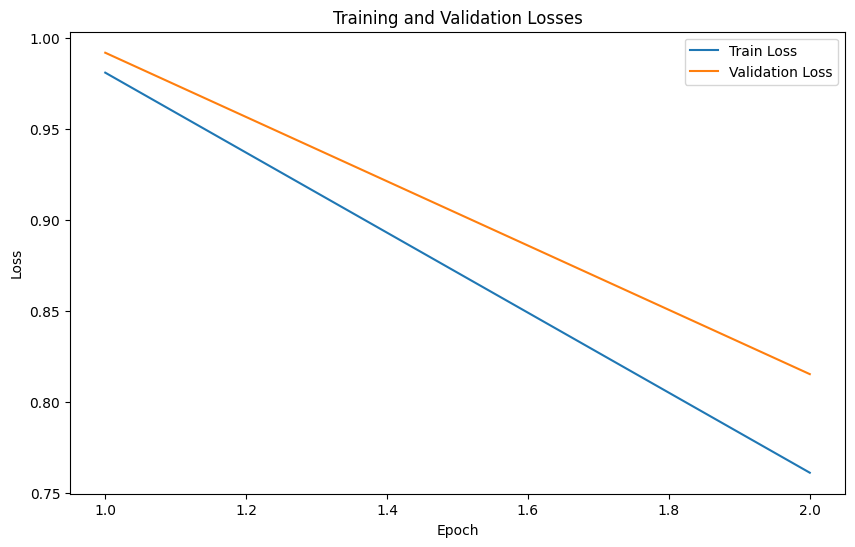

Accuracy: 0.701
Balanced Accuracy: 0.590
AUC: 0.938


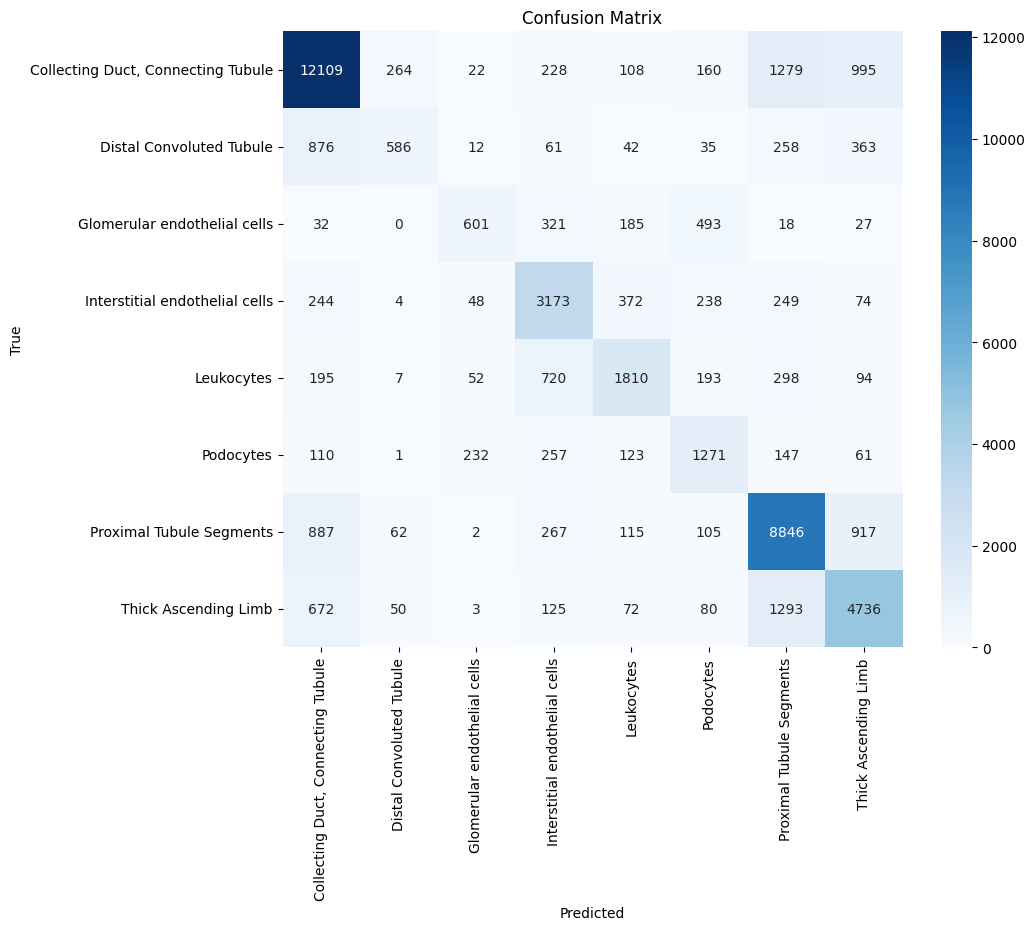

MODEL 1
Train Epoch: 0 [0/121027 (0%)]	Loss: 2.302703
Train Epoch: 0 [3600/121027 (3%)]	Loss: 1.371714
Train Epoch: 0 [7200/121027 (6%)]	Loss: 1.328186
Train Epoch: 0 [10800/121027 (9%)]	Loss: 1.211859
Train Epoch: 0 [14400/121027 (12%)]	Loss: 1.068637
Train Epoch: 0 [18000/121027 (15%)]	Loss: 1.014996
Train Epoch: 0 [21600/121027 (18%)]	Loss: 1.079661
Train Epoch: 0 [25200/121027 (21%)]	Loss: 1.054900
Train Epoch: 0 [28800/121027 (24%)]	Loss: 1.042305
Train Epoch: 0 [32400/121027 (27%)]	Loss: 1.009867
Train Epoch: 0 [36000/121027 (30%)]	Loss: 0.941148
Train Epoch: 0 [39600/121027 (33%)]	Loss: 0.860274
Train Epoch: 0 [43200/121027 (36%)]	Loss: 0.949854
Train Epoch: 0 [46800/121027 (39%)]	Loss: 0.920380
Train Epoch: 0 [50400/121027 (42%)]	Loss: 0.957056
Train Epoch: 0 [54000/121027 (45%)]	Loss: 0.961475
Train Epoch: 0 [57600/121027 (48%)]	Loss: 0.950016
Train Epoch: 0 [61200/121027 (51%)]	Loss: 0.873047
Train Epoch: 0 [64800/121027 (54%)]	Loss: 0.974998
Train Epoch: 0 [68400/121027 (57%

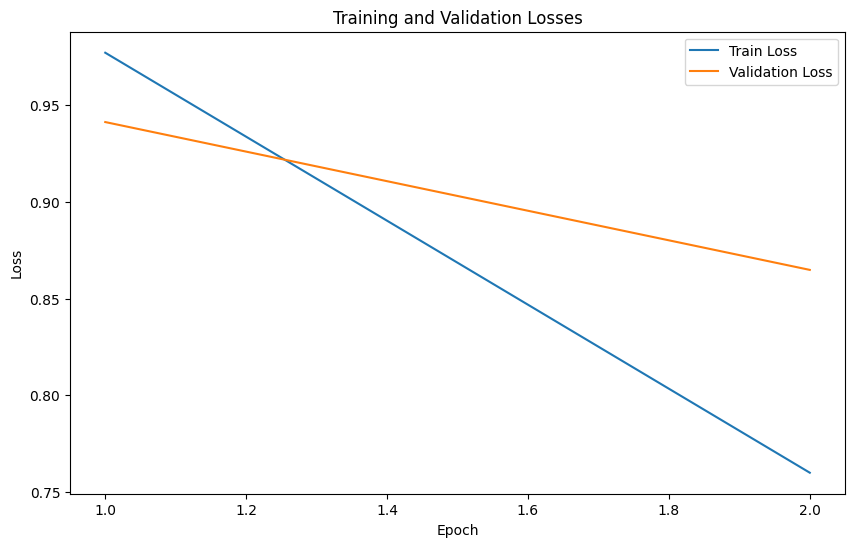

Accuracy: 0.685
Balanced Accuracy: 0.577
AUC: 0.935


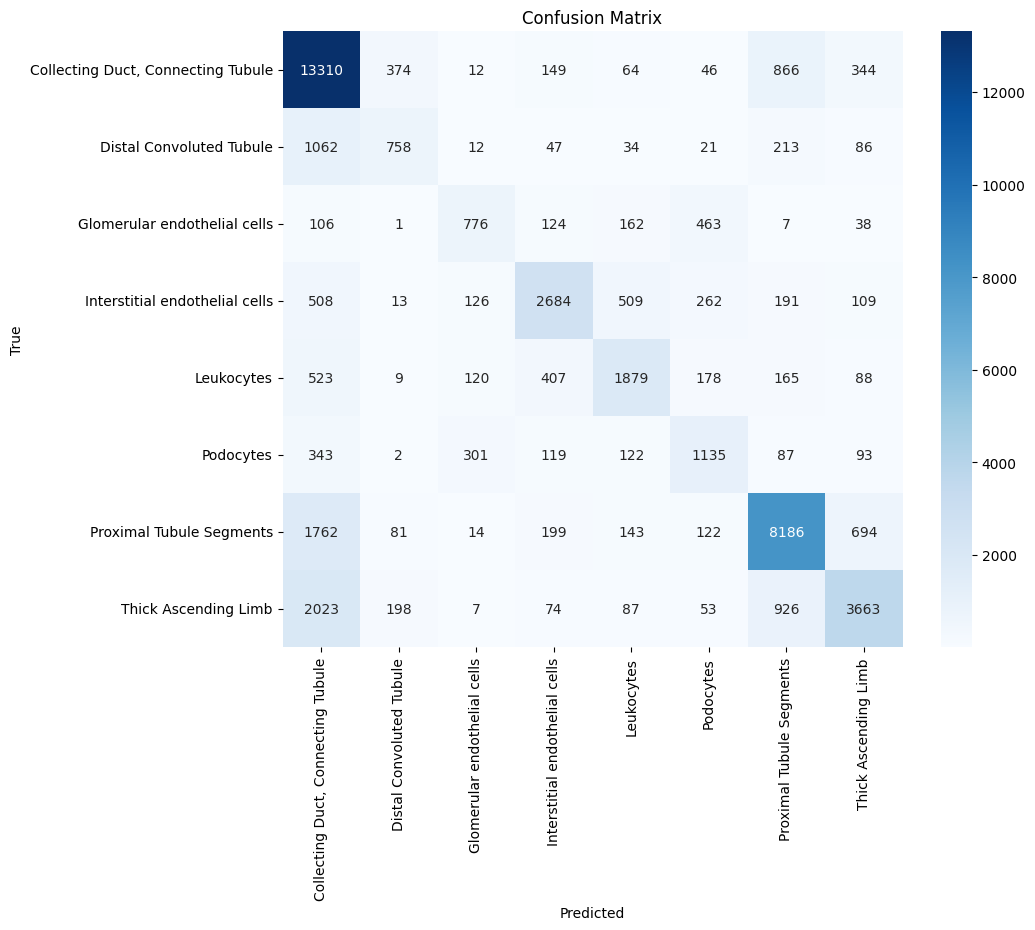

MODEL 2
Train Epoch: 0 [0/121027 (0%)]	Loss: 2.373750
Train Epoch: 0 [3600/121027 (3%)]	Loss: 1.427418
Train Epoch: 0 [7200/121027 (6%)]	Loss: 1.193979
Train Epoch: 0 [10800/121027 (9%)]	Loss: 1.174964
Train Epoch: 0 [14400/121027 (12%)]	Loss: 1.082322
Train Epoch: 0 [18000/121027 (15%)]	Loss: 1.057249
Train Epoch: 0 [21600/121027 (18%)]	Loss: 1.111249
Train Epoch: 0 [25200/121027 (21%)]	Loss: 1.005608
Train Epoch: 0 [28800/121027 (24%)]	Loss: 1.047207
Train Epoch: 0 [32400/121027 (27%)]	Loss: 0.965143
Train Epoch: 0 [36000/121027 (30%)]	Loss: 0.947631
Train Epoch: 0 [39600/121027 (33%)]	Loss: 0.945555
Train Epoch: 0 [43200/121027 (36%)]	Loss: 0.940065
Train Epoch: 0 [46800/121027 (39%)]	Loss: 0.935101
Train Epoch: 0 [50400/121027 (42%)]	Loss: 0.905627
Train Epoch: 0 [54000/121027 (45%)]	Loss: 0.966493
Train Epoch: 0 [57600/121027 (48%)]	Loss: 0.939230
Train Epoch: 0 [61200/121027 (51%)]	Loss: 0.939577
Train Epoch: 0 [64800/121027 (54%)]	Loss: 1.019273
Train Epoch: 0 [68400/121027 (57%

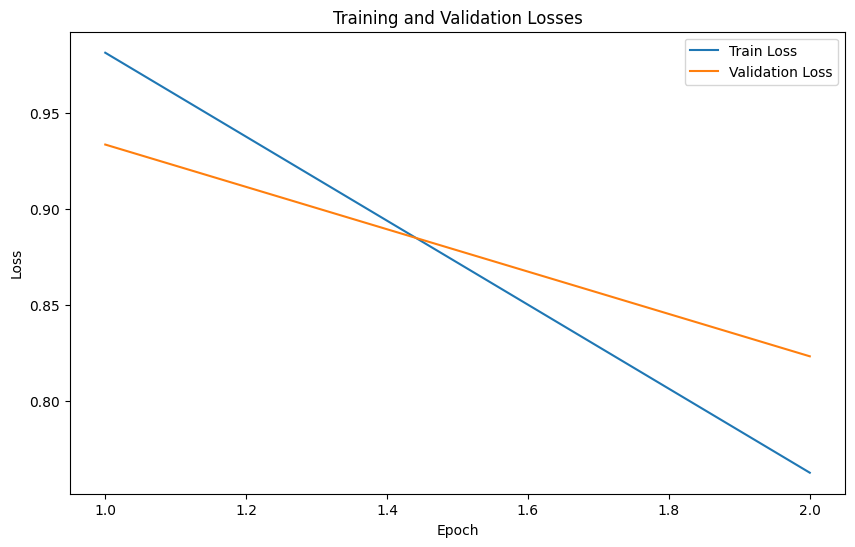

Accuracy: 0.697
Balanced Accuracy: 0.592
AUC: 0.937


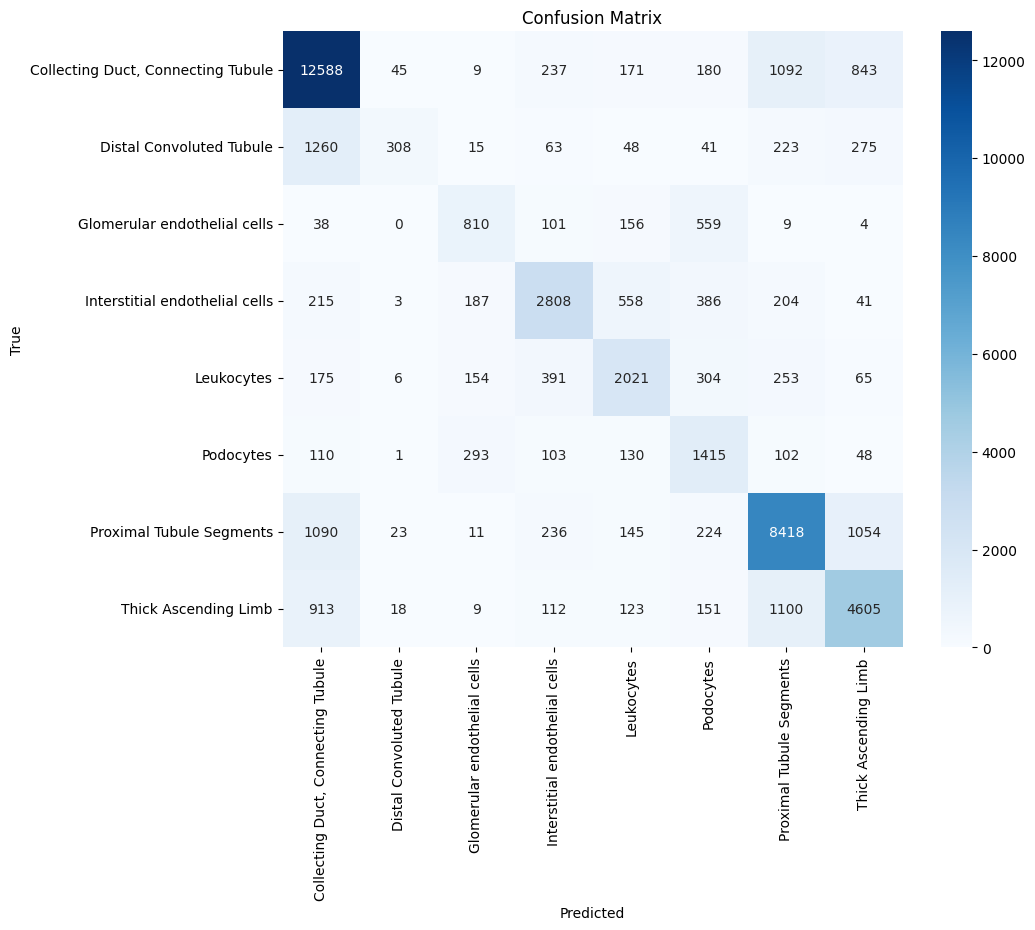

MODEL 3
Train Epoch: 0 [0/121027 (0%)]	Loss: 2.400877
Train Epoch: 0 [3600/121027 (3%)]	Loss: 1.469185
Train Epoch: 0 [7200/121027 (6%)]	Loss: 1.199017
Train Epoch: 0 [10800/121027 (9%)]	Loss: 1.155339
Train Epoch: 0 [14400/121027 (12%)]	Loss: 1.048271
Train Epoch: 0 [18000/121027 (15%)]	Loss: 1.001179
Train Epoch: 0 [21600/121027 (18%)]	Loss: 0.989727
Train Epoch: 0 [25200/121027 (21%)]	Loss: 1.059259
Train Epoch: 0 [28800/121027 (24%)]	Loss: 1.019946
Train Epoch: 0 [32400/121027 (27%)]	Loss: 0.990059
Train Epoch: 0 [36000/121027 (30%)]	Loss: 0.914010
Train Epoch: 0 [39600/121027 (33%)]	Loss: 0.946191
Train Epoch: 0 [43200/121027 (36%)]	Loss: 1.046200
Train Epoch: 0 [46800/121027 (39%)]	Loss: 1.018809
Train Epoch: 0 [50400/121027 (42%)]	Loss: 1.021492
Train Epoch: 0 [54000/121027 (45%)]	Loss: 0.824398
Train Epoch: 0 [57600/121027 (48%)]	Loss: 1.046957
Train Epoch: 0 [61200/121027 (51%)]	Loss: 0.858791
Train Epoch: 0 [64800/121027 (54%)]	Loss: 0.910618
Train Epoch: 0 [68400/121027 (57%

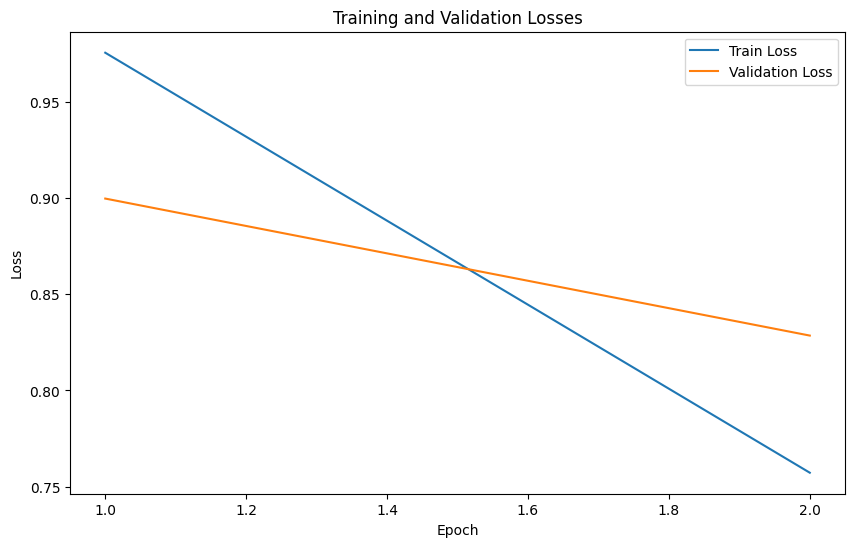

Accuracy: 0.698
Balanced Accuracy: 0.584
AUC: 0.937


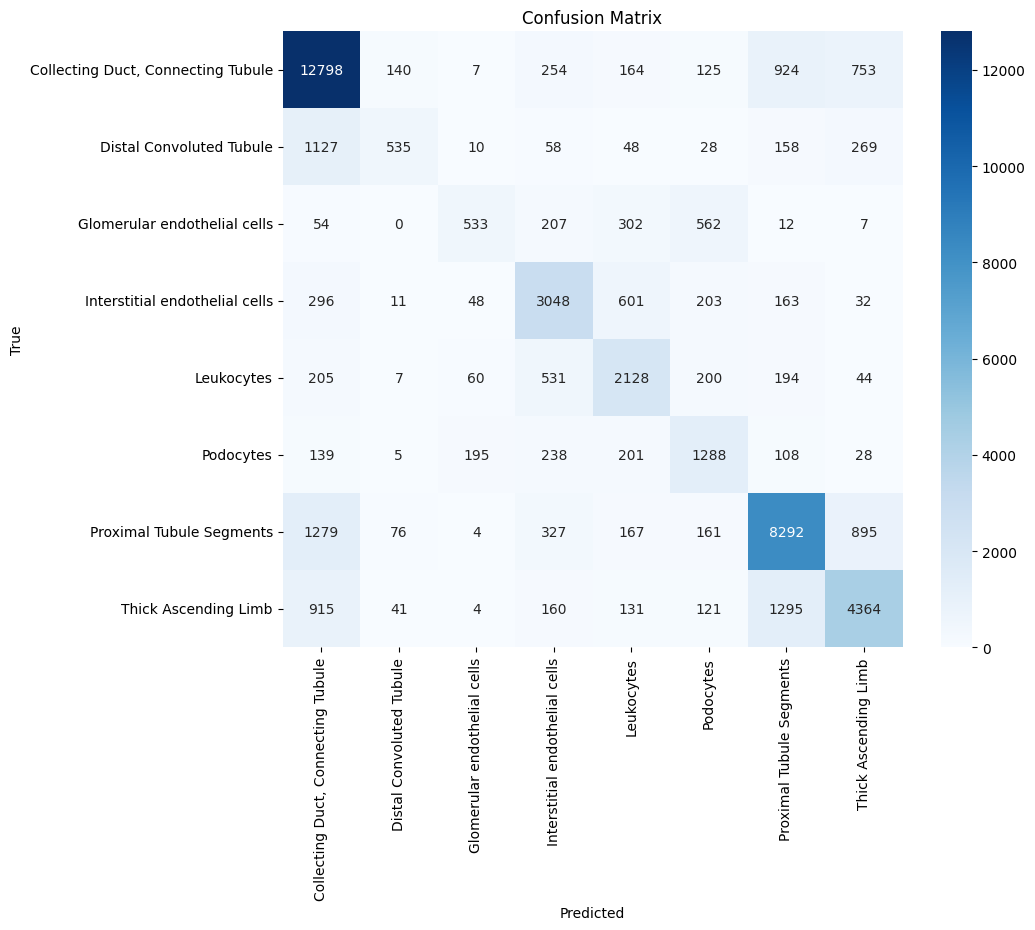

MODEL 4
Train Epoch: 0 [0/121028 (0%)]	Loss: 2.306212
Train Epoch: 0 [3600/121028 (3%)]	Loss: 1.385867
Train Epoch: 0 [7200/121028 (6%)]	Loss: 1.098519
Train Epoch: 0 [10800/121028 (9%)]	Loss: 1.126805
Train Epoch: 0 [14400/121028 (12%)]	Loss: 1.131484
Train Epoch: 0 [18000/121028 (15%)]	Loss: 1.209343
Train Epoch: 0 [21600/121028 (18%)]	Loss: 1.080765
Train Epoch: 0 [25200/121028 (21%)]	Loss: 0.972690
Train Epoch: 0 [28800/121028 (24%)]	Loss: 0.992566
Train Epoch: 0 [32400/121028 (27%)]	Loss: 0.925537
Train Epoch: 0 [36000/121028 (30%)]	Loss: 1.005317
Train Epoch: 0 [39600/121028 (33%)]	Loss: 0.979417
Train Epoch: 0 [43200/121028 (36%)]	Loss: 1.004192
Train Epoch: 0 [46800/121028 (39%)]	Loss: 0.890487
Train Epoch: 0 [50400/121028 (42%)]	Loss: 0.886400
Train Epoch: 0 [54000/121028 (45%)]	Loss: 0.921169
Train Epoch: 0 [57600/121028 (48%)]	Loss: 0.836520
Train Epoch: 0 [61200/121028 (51%)]	Loss: 0.885805
Train Epoch: 0 [64800/121028 (54%)]	Loss: 0.953951
Train Epoch: 0 [68400/121028 (57%

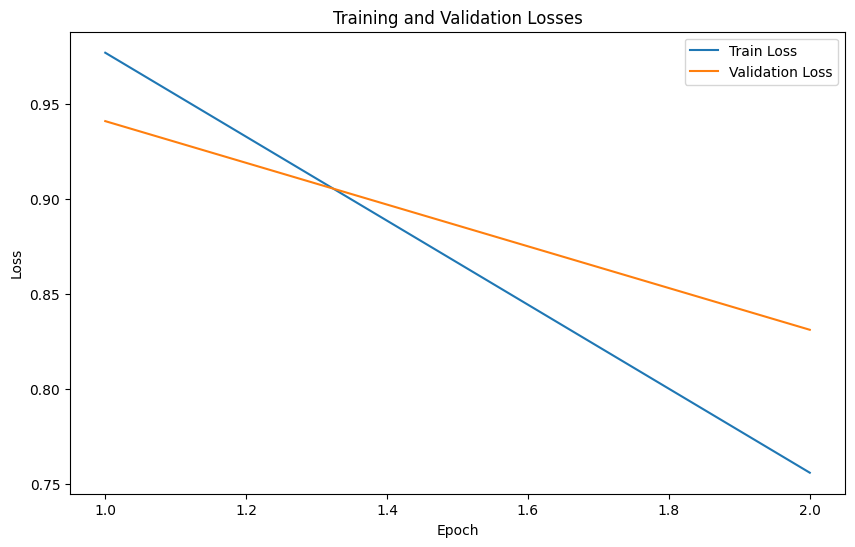

Accuracy: 0.697
Balanced Accuracy: 0.590
AUC: 0.939


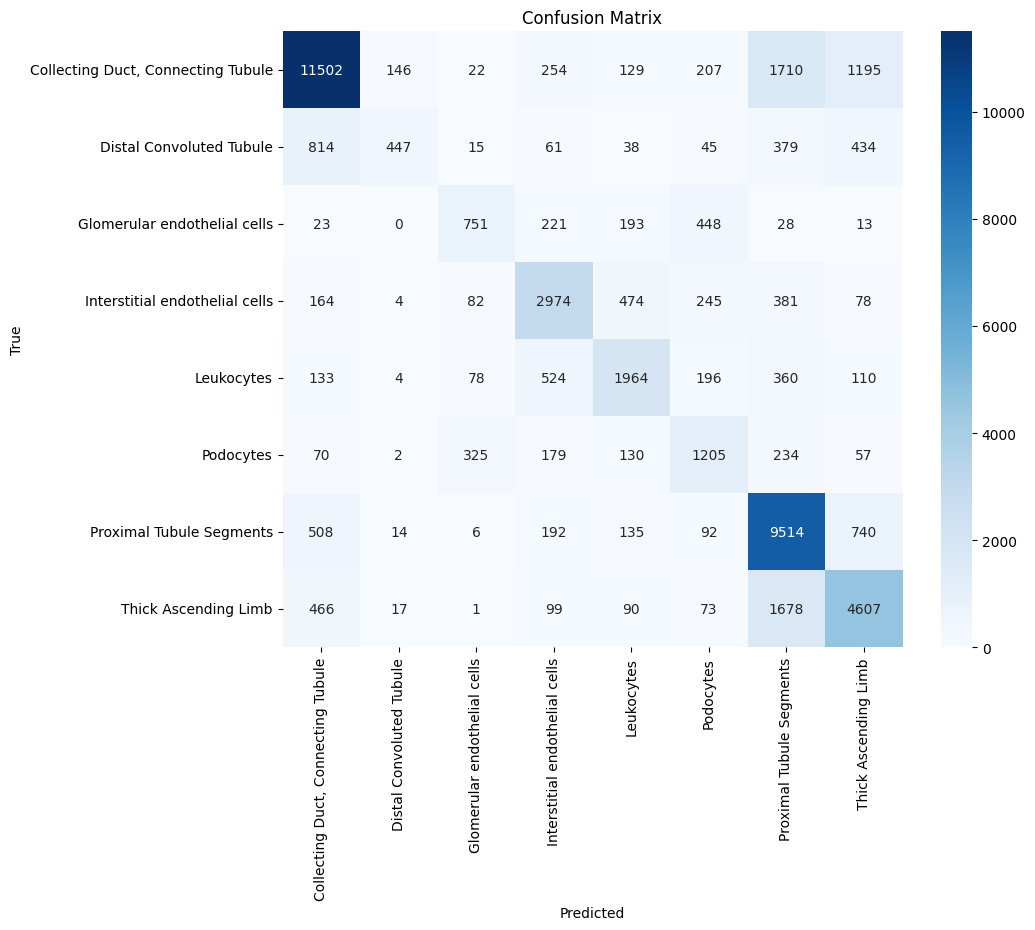

In [9]:
models = []
for i in range(5):
    print('MODEL ' + str(i))
    model = tr.train_resnet18(
        dataflag,
        train_loader=train_loaders[i],
        val_loader=val_loaders[i],
        test_loader=test_loader,
        num_epochs=2,    
        learning_rate=0.0001,
        device='cuda:1',
        random_seed=42  # Set a fixed seed for reproducibility
    )
    models.append(model)

Accuracy: 0.724
Balanced Accuracy: 0.615
AUC: 0.947


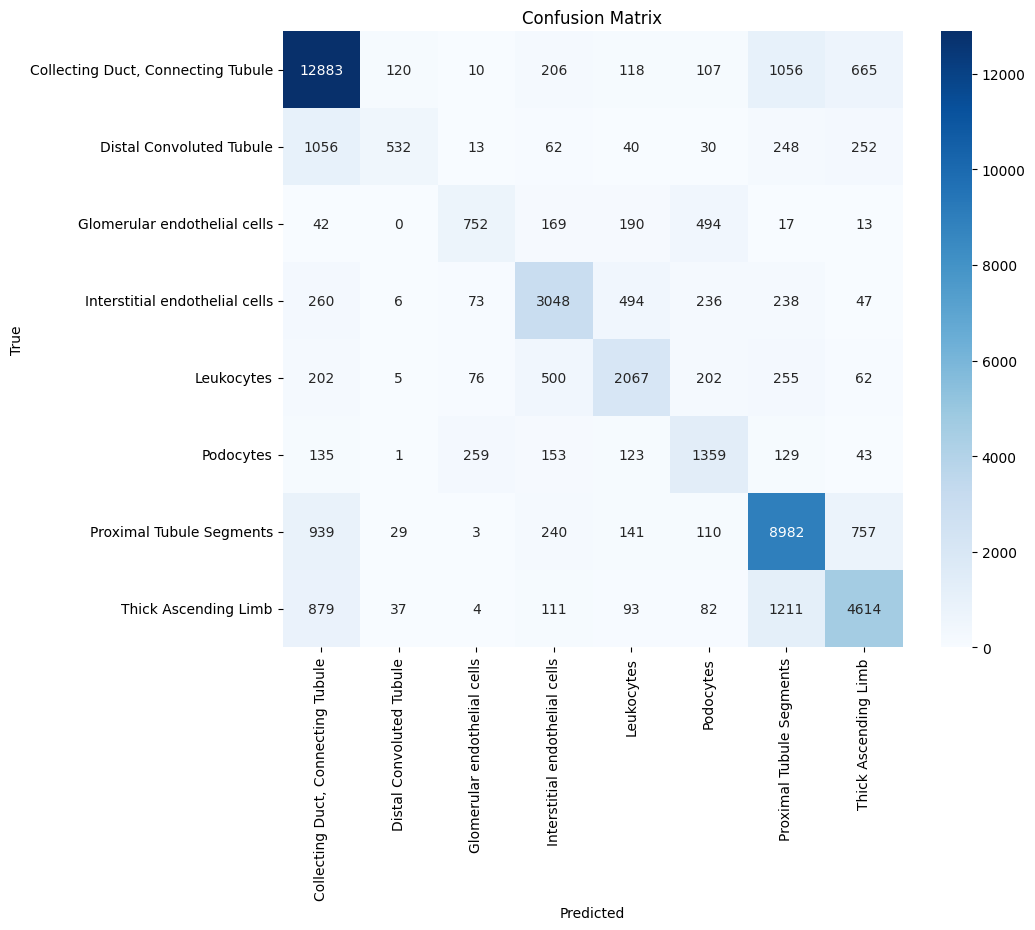

In [10]:
tr.evaluate_model(model=models, test_loader=test_loader, data_flag=dataflag, device='cuda:1')

In [11]:
for i, model in enumerate(models):
    tr.save_model(model, path=f'models/224x224/resnet18_{dataflag}_224_{i}.pt')

Model saved to models/224x224/resnet18_tissuemnist_224_0.pt
Model saved to models/224x224/resnet18_tissuemnist_224_1.pt
Model saved to models/224x224/resnet18_tissuemnist_224_2.pt
Model saved to models/224x224/resnet18_tissuemnist_224_3.pt
Model saved to models/224x224/resnet18_tissuemnist_224_4.pt
